In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
sns.set_context("paper")
EVAL_DATA = Path().absolute().parents[0] / "eval_data"
list(EVAL_DATA.iterdir())

[PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/pocket_clusters_with_klifs.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/egnnr_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/pocket_klifs_metadata.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/README.md'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/train_runs.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/dti_eval_data.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/dti_runs.csv'),
 PosixPath('/Users/joschka/projects/kinodata-docked-rescore/eval_data/pocket_clusters_with_klifs_full.csv')]

## Load eval data

In [2]:
eval_data = pd.read_csv(EVAL_DATA / "eval_data.csv")
eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,5.668407,44685,GIN,scaffold,4,6.000000,6.000000
1,5.251923,44685,GIN,pocket,4,6.000000,6.000000
2,6.395972,44685,EGNN,scaffold,4,6.000000,6.000000
3,5.828227,44685,EGNN,pocket,4,6.000000,6.000000
4,4.179743,105738,GIN,scaffold,4,8.376751,8.376751


In [3]:
dti_eval_data = pd.read_csv(EVAL_DATA / "dti_eval_data.csv")
dti_eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,7.199682,198998,DTI,scaffold,0,5.853872,5.853872
1,7.647483,198998,DTI,scaffold,1,5.853872,5.853872
2,6.981037,198998,DTI,random,2,5.853872,5.853872
3,7.434746,198998,DTI,pocket,3,5.853872,5.853872
4,6.067016,198998,DTI,random,3,5.853872,5.853872


In [4]:
egnnr_eval_data = pd.read_csv(EVAL_DATA / "egnnr_eval_data.csv")
egnnr_eval_data.head()

,pred,ident,model,split,split_seed,activities.standard_value,target
0,6.306590,13841248,EGNN (R),random,4,6.136677,6.136677
1,6.952018,13841248,EGNN (R),random,3,6.136677,6.136677
2,7.810676,17641064,EGNN (R),random,4,7.995679,7.995679
3,7.670426,17641064,EGNN (R),random,4,7.995679,7.995679
4,8.113914,17641064,EGNN (R),scaffold,3,7.995679,7.995679


In [5]:
eval_data = pd.concat((eval_data, dti_eval_data, egnnr_eval_data), axis=0).reset_index()
eval_data.head()

,index,pred,ident,model,split,split_seed,activities.standard_value,target
0,0,5.668407,44685,GIN,scaffold,4,6.000000,6.000000
1,1,5.251923,44685,GIN,pocket,4,6.000000,6.000000
2,2,6.395972,44685,EGNN,scaffold,4,6.000000,6.000000
3,3,5.828227,44685,EGNN,pocket,4,6.000000,6.000000
4,4,4.179743,105738,GIN,scaffold,4,8.376751,8.376751


### Calculate absolute prediction errors
(and filter some weird outliers)

In [6]:
eval_data["error"] = (eval_data["pred"] - eval_data["target"]).abs()

In [7]:
eval_data[eval_data["error"] > 100] # ????

,index,pred,ident,model,split,split_seed,activities.standard_value,target,error
118899,3593,-178.071060,3603328,DTI,pocket,1,6.150581,6.150581,184.221641
118902,3596,-177.863556,3603332,DTI,pocket,1,6.534617,6.534617,184.398173
129911,14605,-177.935532,3603336,DTI,pocket,1,6.675718,6.675718,184.611250
134831,19525,-177.935532,3603326,DTI,pocket,1,8.522879,8.522879,186.458411
134833,19527,-178.013229,3603327,DTI,pocket,1,7.853872,7.853872,185.867101
134835,19529,-177.849365,3603330,DTI,pocket,1,8.522879,8.522879,186.372244
134837,19531,-177.269547,3603334,DTI,pocket,1,6.028260,6.028260,183.297807
134838,19532,-177.923294,3603335,DTI,pocket,1,6.829738,6.829738,184.753032
134839,19533,-177.931412,3603337,DTI,pocket,1,4.566342,4.566342,182.497754
134843,19537,-178.113876,3603342,DTI,pocket,1,8.698970,8.698970,186.812846


In [8]:
eval_data = eval_data[eval_data["error"] < 100]

In [9]:
# sanity check that we use the same targets for all models
assert (eval_data.groupby("ident")["target"].std() == 0).all()

### Define model full names, useful for plotting

In [10]:
full_names = {
    "EGNN (R)": "Complex-EGNN (R)",
    "EGNN": "Complex-EGNN",
    "GIN": "Ligand-GNN",
    "DTI": "KiSSim DeepDTA"
}
eval_data["model_full_name"] = eval_data["model"].apply(full_names.get)
eval_data.head()

,index,pred,ident,model,split,split_seed,activities.standard_value,target,error,model_full_name
0,0,5.668407,44685,GIN,scaffold,4,6.000000,6.000000,0.331593,Ligand-GNN
1,1,5.251923,44685,GIN,pocket,4,6.000000,6.000000,0.748077,Ligand-GNN
2,2,6.395972,44685,EGNN,scaffold,4,6.000000,6.000000,0.395972,Complex-EGNN
3,3,5.828227,44685,EGNN,pocket,4,6.000000,6.000000,0.171773,Complex-EGNN
4,4,4.179743,105738,GIN,scaffold,4,8.376751,8.376751,4.197008,Ligand-GNN


### Calculate test metrics
* Correlation of test prediction and target
* Mean absolute error

In [11]:
corr_data = eval_data.groupby(["split", "model_full_name", "split_seed"])[["pred", "target"]].corr().iloc[0::2, -1]
corr_data = corr_data.unstack().reset_index().rename(columns={"pred": "test_corr"})
corr_data.head()

,split,model_full_name,split_seed,test_corr
0,pocket,Complex-EGNN,0,0.419050
1,pocket,Complex-EGNN,1,0.375618
2,pocket,Complex-EGNN,2,0.348831
3,pocket,Complex-EGNN,3,0.227266
4,pocket,Complex-EGNN,4,0.271939


In [12]:
mae_data = eval_data.groupby(["split", "model_full_name", "split_seed"])["error"].mean().reset_index()
mae_data.head()

,split,model_full_name,split_seed,error
0,pocket,Complex-EGNN,0,0.849410
1,pocket,Complex-EGNN,1,0.940820
2,pocket,Complex-EGNN,2,0.798744
3,pocket,Complex-EGNN,3,0.895928
4,pocket,Complex-EGNN,4,0.950526


(0.0, 2.0)

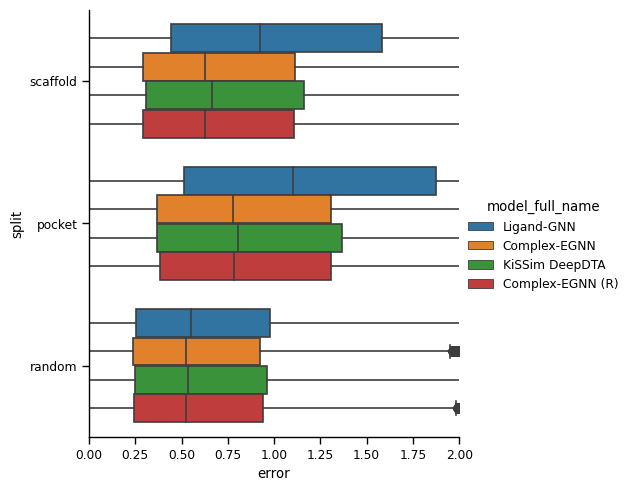

In [13]:
sns.catplot(eval_data, x="error", y="split", hue="model_full_name", kind="box")
plt.xlim(left=0, right=2)

In [14]:
corr_data.groupby(["split", "model_full_name"])["test_corr"].agg(["mean", "std"])

mean       std
split    model_full_name                     
pocket   Complex-EGNN      0.328541  0.077911
         Complex-EGNN (R)  0.312338  0.100640
         KiSSim DeepDTA    0.302315  0.088441
         Ligand-GNN        0.127514  0.080811
random   Complex-EGNN      0.705912  0.006077
         Complex-EGNN (R)  0.703090  0.003072
         KiSSim DeepDTA    0.688463  0.005211
         Ligand-GNN        0.680698  0.007914
scaffold Complex-EGNN      0.571332  0.047771
         Complex-EGNN (R)  0.585629  0.036537
         KiSSim DeepDTA    0.535466  0.062262
         Ligand-GNN        0.313690  0.040838

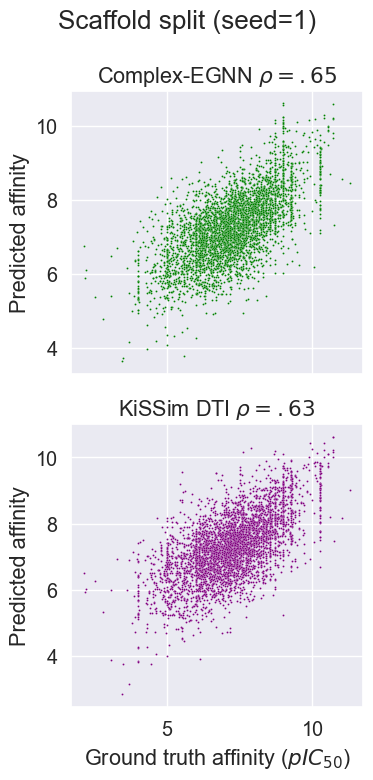

In [15]:
split, seed = "scaffold", 1
sns.set(font_scale=1.3)
scaf_1 = eval_data.query(f"split == '{split}' and split_seed == {seed}")
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8), sharex=True, sharey=False)
sns.scatterplot(scaf_1.query("model == 'EGNN'"), x="target", y="pred", color="green", ax=ax1, s=2)
sns.scatterplot(scaf_1.query("model == 'DTI'"), x="target", y="pred", color="purple", ax=ax2, s=2)
for ax in (ax1, ax2):
    ax.set_ylabel("Predicted affinity")
    ax.set_xlabel("Ground truth affinity (${pIC}_{50}$)")

ax1.set_title("Complex-EGNN $\\rho=.65$") 
ax2.set_title("KiSSim DTI $\\rho=.63$") 
f.suptitle("Scaffold split (seed=1)")
f.tight_layout()

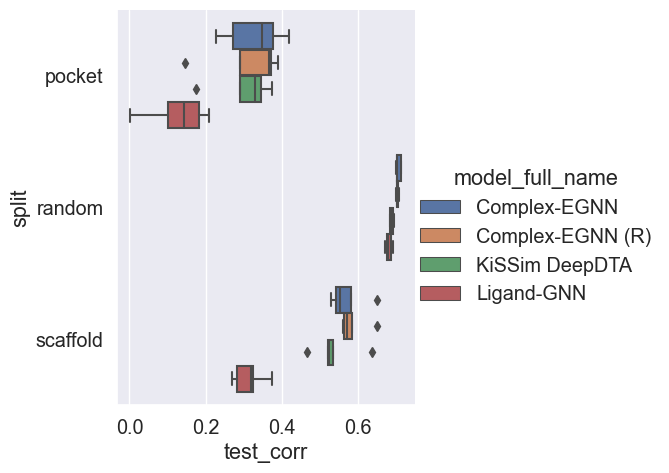

In [16]:
sns.catplot(corr_data, x="test_corr", y="split", kind="box", hue="model_full_name")

### Model improvement plot
Let $r_1$ and $r_2$ be the correlation of prediction and target of two models. We define the relative improvement of model $1$ over $2$ as
$$
\delta_{1,2} = \frac{r_1}{r_2} - 1 \in (-\infty, \infty)
$$

In [17]:
corr_diff = corr_data.groupby(["split", "split_seed"])[["model_full_name", "test_corr"]].apply(lambda x: x.test_corr.values[1] / x.test_corr.values[2])
corr_diff = corr_diff.reset_index().rename(columns={0: "corr_ratio"})
corr_diff["improvement"] = (corr_diff["corr_ratio"] - 1) * 100 # %
corr_diff["improvement"].describe()

count    15.000000
mean      8.379631
std      21.507416
min     -15.844651
25%       1.464016
50%       2.495457
75%       8.974918
max      78.010236
Name: improvement, dtype: float64

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


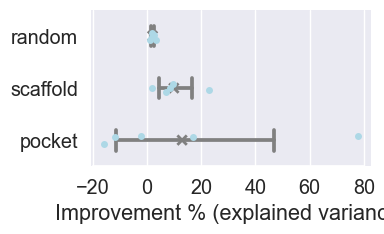

In [18]:
f, ax = plt.subplots(figsize=(4, 2.5))
sns.set_theme(style="ticks")
sns.stripplot(corr_diff, x="improvement", y="split", size=5, linewidth=0, color="lightblue", order=["random", "scaffold", "pocket"])
# sns.boxplot(corr_diff, x="corr. delta", y="split", whis=[0, 100], width=.6, color=".8", meanline=True, order=["random", "scaffold", "pocket"])
sns.pointplot(corr_diff, x="improvement", y="split", order=["random", "scaffold", "pocket"], join=False, color=".5", capsize=.4, markers="x")
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set_xlabel(r"Improvement % (explained variance)")
sns.despine(trim=True, left=True)
# ax.set_xlim(left=0, right=2.0)
f.tight_layout()
f.savefig("corr_diff_kinodata.pdf")

In [19]:
eval_data["abs_error"] = (eval_data["pred"] - eval_data["activities.standard_value"]).abs()

In [20]:
mae = (
    eval_data.groupby(["split", "split_seed", "model"])["abs_error"]
    .mean()
    .to_frame()
    .reset_index()
    .rename(columns={"abs_error": "mae"})
)
print(mae.groupby(["model", "split"])["mae"].agg(["mean", "std"]))

                       mean       std
model    split                       
DTI      pocket    0.923207  0.081473
         random    0.681560  0.008739
         scaffold  0.811859  0.030459
EGNN     pocket    0.887086  0.063667
         random    0.658575  0.013575
         scaffold  0.779452  0.021651
EGNN (R) pocket    0.902184  0.038913
         random    0.663433  0.009449
         scaffold  0.771132  0.022458
GIN      pocket    1.257423  0.181086
         random    0.687846  0.009813
         scaffold  1.097443  0.096543


In [21]:
import biotite.sequence.align as align
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from kinodata.data.utils. similarity import _normalize_score_matrix

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
blosum = align.SubstitutionMatrix.std_protein_matrix()
score_matrix = blosum.score_matrix()
alph = blosum.get_alphabet1()
score_matrix = _normalize_score_matrix(score_matrix)
score_matrix

array([[1.        , 0.39223227, 0.2236068 , 0.35355339, 0.2236068 ,
        0.4472136 , 0.20412415, 0.375     , 0.35355339, 0.375     ,
        0.35355339, 0.2236068 , 0.31980107, 0.35355339, 0.35355339,
        0.625     , 0.47140452, 0.5       , 0.09128709, 0.21320072,
        0.25      , 0.375     , 0.81649658, 0.        ],
       [0.39223227, 1.        , 0.0877058 , 0.        , 0.1754116 ,
        0.0877058 , 0.08006408, 0.2941742 , 0.09245003, 0.2941742 ,
        0.2773501 , 0.0877058 , 0.0836242 , 0.09245003, 0.09245003,
        0.2941742 , 0.2773501 , 0.2941742 , 0.14322297, 0.1672484 ,
        0.09805807, 0.09805807, 0.32025631, 0.        ],
       [0.2236068 , 0.0877058 , 1.        , 0.63245553, 0.1       ,
        0.3       , 0.27386128, 0.1118034 , 0.31622777, 0.        ,
        0.10540926, 0.5       , 0.28603878, 0.42163702, 0.21081851,
        0.4472136 , 0.31622777, 0.1118034 , 0.        , 0.09534626,
        0.89442719, 0.55901699, 0.54772256, 0.        ],
       [0.353

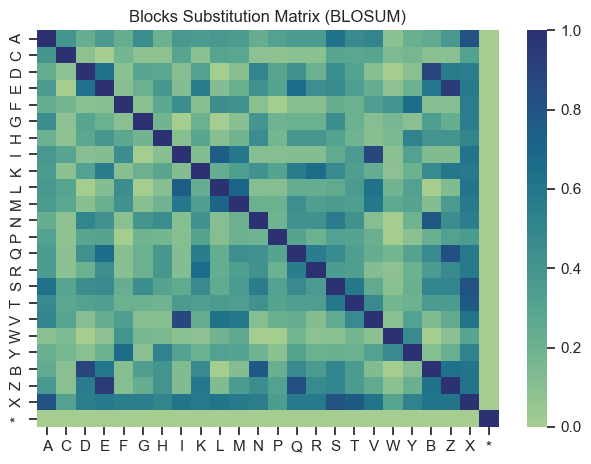

In [23]:
# sns.set_context("talk")
hm = sns.heatmap(score_matrix, xticklabels=alph, yticklabels=alph, cmap="crest", fmt="g")
hm.set_title("Blocks Substitution Matrix (BLOSUM)")
plt.tight_layout()

In [24]:
EGFR = "KVLGSGAFGTVYKVAIKVLEILDEAYVMAGVGPYVSRLLGIQLVTQLMPYGCLLDHVREYLEDVRLVHRDLAARNVLVITDFGLA"
KDR = "KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVEFCKFGNLSTYLRSFLASRKCIHRDLAARNILLICDFGLA"

In [25]:
iEGFR = alph.encode_multiple(EGFR)
iKDR = alph.encode_multiple(KDR)

In [26]:
data = pd.DataFrame({
    "Residue sim.": score_matrix[iEGFR, iKDR]
}, index=[f"{a}{b}" for a,b in zip(EGFR, KDR)])

In [27]:
sample = data.iloc[:9]
dummy = pd.DataFrame({
    "Residue sim.": 0
}, index=["${\\dots}$"])
sample = pd.concat((sample, dummy))
sample

,Residue sim.
KK,1.000000
VP,0.213201
LL,1.000000
GG,1.000000
SR,0.353553
GG,1.000000
AA,1.000000
FF,1.000000
GG,1.000000
${\dots}$,0.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'KK'),
  Text(0, 1.5, 'VP'),
  Text(0, 2.5, 'LL'),
  Text(0, 3.5, 'GG'),
  Text(0, 4.5, 'SR'),
  Text(0, 5.5, 'GG'),
  Text(0, 6.5, 'AA'),
  Text(0, 7.5, 'FF'),
  Text(0, 8.5, 'GG'),
  Text(0, 9.5, '${\\dots}$')])

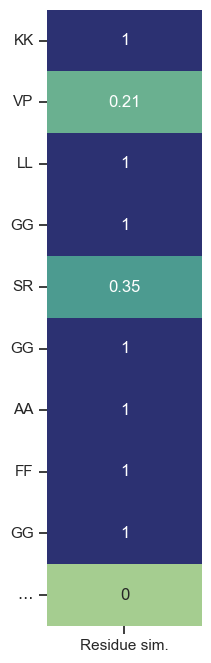

In [28]:
f, ax = plt.subplots(figsize=(2, 8))
sns.heatmap(sample, cmap="crest", vmin=score_matrix.min(), vmax=score_matrix.max(), annot=True, cbar=False)
plt.yticks(rotation=0)